# NRP Tutorial: Baseball experiment solution

In this experiment folder, you will find the state machine and the transfer functions to solve the tutorial baseball experiment.
This notebook only contains the solution for the second part of the exercise, the offline analysis with the virtual coach.

# Exercise 2: Offline analysis and optimization with virtual coach

In [1]:
# disable global logging from the virtual coach
import logging
logging.disable(logging.INFO)
logging.getLogger('rospy').propagate = False
logging.getLogger('rosout').propagate = False

In [2]:
# log into the virtual coach, update with your credentials
try:
    from hbp_nrp_virtual_coach.virtual_coach import VirtualCoach
    vc = VirtualCoach(environment='local')
except ImportError as e:
    print(e)
    print("You have to start this notebook with the command:\
          cle-virtual-coach jupyter notebook")
    raise e

## First steps with the Virtual Coach

The virtual coach launch experiments return a well-documented simulation object with which you can interact:

In [3]:
sim = vc.launch_experiment('ExDTutorialBaseballSolution')

In [4]:
methods = [method for method in dir(sim) if not method.startswith('_')]
print('Available method on the simulation object:\n{}'.format('\n'.join(methods)))

Available method on the simulation object:
add_state_machine
add_transfer_function
delete_state_machine
delete_transfer_function
edit_brain
edit_populations
edit_state_machine
edit_transfer_function
get_brain
get_csv_data
get_populations
get_state
get_state_machine
get_transfer_function
launch
pause
print_csv_file_names
print_state_machines
print_transfer_functions
register_status_callback
reset
start
stop


In [5]:
sim.register_status_callback?

If you have the frontend running, you can see that there is a running instance of this experiment if you click on it.
You can stop the experiment either with the frontend or with the virtual coach:

In [6]:
sim.stop()

## Visualization and optimization

In the coming cells, you will have to use the virtual coach to optimize a metric by running the expriments multiple times.

Specifically, we will try to find the best synaptic weight between the input and the output populations.
The objective we try to maximize is the absolute **x** position of the ball (the ball is fired in the negative **x** direction, c.f. the StateMachine).

For this purpose we need:
1. the brain to be parametrizable
2. a way to access data from the experiment (the ball position)

### The brain

Here is the brain file from the **tutorial_baseball_exercise**. Note that the synaptic weight is replaced with the template parameter **{syn_weight}**:

In [7]:
brain_template = '''
# -*- coding: utf-8 -*-
"""
Tutorial brain for the baseball experiment
"""

# pragma: no cover
__author__ = 'Jacques Kaiser'

from hbp_nrp_cle.brainsim import simulator as sim
import numpy as np

n_sensors = 20
n_motors = 1

sensors = sim.Population(n_sensors, cellclass=sim.IF_curr_exp())
motors = sim.Population(n_motors, cellclass=sim.IF_curr_exp())
sim.Projection(sensors, motors, sim.AllToAllConnector(),
               sim.StaticSynapse(weight={syn_weight}))
'''

### The (additional) transfer function

To record data from the experiment, we add a special type of transfer functions: **MapCSVRecorder**..
You could also add this transfer functions as a python file in the **Experiments/my_first_experiment** folder and reference it in the **.bibi**, the results would be identical.

In [8]:
record_ball_tf = \
'''
# Imported Python Transfer Function
import numpy as np
import sensor_msgs.msg

@nrp.MapCSVRecorder("ball_recorder", filename="ball_position.csv",
                    headers=["Time", "px", "py", "pz"])
@nrp.Robot2Neuron()
def record_ball_csv(t, ball_recorder):
    from rospy import ServiceProxy
    from gazebo_msgs.srv import GetModelState

    model_name = 'ball'
    state_proxy = ServiceProxy('/gazebo/get_model_state',
                                    GetModelState, persistent=False)
    ball_state = state_proxy(model_name, "world")

    if ball_state.success:
        current_position = ball_state.pose.position
        ball_recorder.record_entry(t,
                                   current_position.x, 
                                   current_position.y, 
                                   current_position.z)
'''

## Running the experiment with default synaptic weight

Run the experiment with the default synaptic weight, and save the resulting CSV file

In [10]:
import csv
import tempfile
import os

# this name has to match the name passed in the CSV transfer function
csv_name = 'ball_position.csv'
    
def save_position_csv(sim, datadir):
    with open(os.path.join(datadir, csv_name), 'wb') as f:
        cf = csv.writer(f)
        #################################################
        # Insert code here:
        # get the CSV data from the simulation
        #################################################
        csv_data = sim.get_csv_data(csv_name) #solution
        cf.writerows(csv_data)
    
# The function make_on_status() returns a on_status() function
# This is called a "closure": 
# it is here used to pass the sim and datadir objects to on_status()
def make_on_status(sim, datadir):
    def on_status(msg):
        print("Current simulation time: {}".format(msg['simulationTime']))
        if msg['simulationTime'] == 5.0 and sim.get_state() is not 'stopped':
            #################################################
            # Insert code here:
            # 1) pause the simulation, 
            # 2) save the CSV file
            # 3) stop the simulation 
            #################################################
            sim.pause()  #solution
            save_position_csv(sim, datadir)
            sim.stop() #solution
            print("Trial terminated - saved CSV in {}".format(datadir))
            
    return on_status
        
def run_experiment(datadir, brain_params={'syn_weight': 1.0}):
    #################################################
    # Insert code here:
    # 1) launch the experiment
    # 2) add the status callback
    # 3) add the parametrized brain file
    # 4) add the extra CSV TF
    # 5) start the simulation
    #################################################
    brain_file = brain_template.format(**brain_params)
    
    sim = vc.launch_experiment('ExDTutorialBaseballSolution') #solution
    sim.register_status_callback(make_on_status(sim, datadir)) #solution
    sim.add_transfer_function(record_ball_tf) #solution
    sim.edit_brain(brain_file) #solution
    sim.start()
    return sim
    
tmp_folder = tempfile.mkdtemp()
sim=run_experiment(datadir=tmp_folder)

Current simulation time: 0
Current simulation time: 1
Current simulation time: 1
Current simulation time: 2
Current simulation time: 2
Current simulation time: 3
Current simulation time: 4
Current simulation time: 4
Current simulation time: 5
Trial terminated - saved CSV in /tmp/tmp7gxwtI
Current simulation time: 5
ERROR: [2017-08-29 12:36:47,915 - bbp_client.oidc.client] Failed to retrieve data: {"data": null, "message": "Invalid transition (stopped->paused)", "type": "Transition error"}
ERROR: [2017-08-29 12:36:47,917 - rosout] bad callback: <bound method Simulation.__on_status of <hbp_nrp_virtual_coach.simulation.Simulation object at 0x7f4bf47607d0>>
Traceback (most recent call last):
  File "/opt/ros/kinetic/lib/python2.7/dist-packages/rospy/topics.py", line 750, in _invoke_callback
    cb(msg)
  File "/home/vonarnim/Documents/NRP/VirtualCoach/hbp_nrp_virtual_coach/hbp_nrp_virtual_coach/simulation.py", line 275, in __on_status
    callback(status)
  File "<ipython-input-10-3036170d

[ERROR] [1504003007.917306, 5.441000]: bad callback: <bound method Simulation.__on_status of <hbp_nrp_virtual_coach.simulation.Simulation object at 0x7f4bf47607d0>>
Traceback (most recent call last):
  File "/opt/ros/kinetic/lib/python2.7/dist-packages/rospy/topics.py", line 750, in _invoke_callback
    cb(msg)
  File "/home/vonarnim/Documents/NRP/VirtualCoach/hbp_nrp_virtual_coach/hbp_nrp_virtual_coach/simulation.py", line 275, in __on_status
    callback(status)
  File "<ipython-input-10-3036170dd899>", line 31, in on_status
    sim.pause()  #solution
  File "/home/vonarnim/Documents/NRP/VirtualCoach/hbp_nrp_virtual_coach/hbp_nrp_virtual_coach/simulation.py", line 172, in pause
    self.__set_state('paused')
  File "/home/vonarnim/Documents/NRP/VirtualCoach/hbp_nrp_virtual_coach/hbp_nrp_virtual_coach/simulation.py", line 231, in __set_state
    res, _ = self.__oidc_client.request(url, method='PUT', body=json.dumps({'state': state}))
  File "/home/vonarnim/.opt/platform_venv/lib/pytho

Current simulation time: 5
ERROR: [2017-08-29 12:36:48,215 - bbp_client.oidc.client] Failed to retrieve data: {"data": null, "message": "Invalid transition (stopped->paused)", "type": "Transition error"}
ERROR: [2017-08-29 12:36:48,217 - rosout] bad callback: <bound method Simulation.__on_status of <hbp_nrp_virtual_coach.simulation.Simulation object at 0x7f4bf47607d0>>
Traceback (most recent call last):
  File "/opt/ros/kinetic/lib/python2.7/dist-packages/rospy/topics.py", line 750, in _invoke_callback
    cb(msg)
  File "/home/vonarnim/Documents/NRP/VirtualCoach/hbp_nrp_virtual_coach/hbp_nrp_virtual_coach/simulation.py", line 275, in __on_status
    callback(status)
  File "<ipython-input-10-3036170dd899>", line 31, in on_status
    sim.pause()  #solution
  File "/home/vonarnim/Documents/NRP/VirtualCoach/hbp_nrp_virtual_coach/hbp_nrp_virtual_coach/simulation.py", line 172, in pause
    self.__set_state('paused')
  File "/home/vonarnim/Documents/NRP/VirtualCoach/hbp_nrp_virtual_coach/h

[ERROR] [1504003008.217207, 5.441000]: bad callback: <bound method Simulation.__on_status of <hbp_nrp_virtual_coach.simulation.Simulation object at 0x7f4bf47607d0>>
Traceback (most recent call last):
  File "/opt/ros/kinetic/lib/python2.7/dist-packages/rospy/topics.py", line 750, in _invoke_callback
    cb(msg)
  File "/home/vonarnim/Documents/NRP/VirtualCoach/hbp_nrp_virtual_coach/hbp_nrp_virtual_coach/simulation.py", line 275, in __on_status
    callback(status)
  File "<ipython-input-10-3036170dd899>", line 31, in on_status
    sim.pause()  #solution
  File "/home/vonarnim/Documents/NRP/VirtualCoach/hbp_nrp_virtual_coach/hbp_nrp_virtual_coach/simulation.py", line 172, in pause
    self.__set_state('paused')
  File "/home/vonarnim/Documents/NRP/VirtualCoach/hbp_nrp_virtual_coach/hbp_nrp_virtual_coach/simulation.py", line 231, in __set_state
    res, _ = self.__oidc_client.request(url, method='PUT', body=json.dumps({'state': state}))
  File "/home/vonarnim/.opt/platform_venv/lib/pytho

Current simulation time: 5
ERROR: [2017-08-29 12:36:49,216 - bbp_client.oidc.client] Failed to retrieve data: {"data": null, "message": "Invalid transition (stopped->paused)", "type": "Transition error"}
ERROR: [2017-08-29 12:36:49,217 - rosout] bad callback: <bound method Simulation.__on_status of <hbp_nrp_virtual_coach.simulation.Simulation object at 0x7f4bf47607d0>>
Traceback (most recent call last):
  File "/opt/ros/kinetic/lib/python2.7/dist-packages/rospy/topics.py", line 750, in _invoke_callback
    cb(msg)
  File "/home/vonarnim/Documents/NRP/VirtualCoach/hbp_nrp_virtual_coach/hbp_nrp_virtual_coach/simulation.py", line 275, in __on_status
    callback(status)
  File "<ipython-input-10-3036170dd899>", line 31, in on_status
    sim.pause()  #solution
  File "/home/vonarnim/Documents/NRP/VirtualCoach/hbp_nrp_virtual_coach/hbp_nrp_virtual_coach/simulation.py", line 172, in pause
    self.__set_state('paused')
  File "/home/vonarnim/Documents/NRP/VirtualCoach/hbp_nrp_virtual_coach/h

[ERROR] [1504003009.217274, 5.441000]: bad callback: <bound method Simulation.__on_status of <hbp_nrp_virtual_coach.simulation.Simulation object at 0x7f4bf47607d0>>
Traceback (most recent call last):
  File "/opt/ros/kinetic/lib/python2.7/dist-packages/rospy/topics.py", line 750, in _invoke_callback
    cb(msg)
  File "/home/vonarnim/Documents/NRP/VirtualCoach/hbp_nrp_virtual_coach/hbp_nrp_virtual_coach/simulation.py", line 275, in __on_status
    callback(status)
  File "<ipython-input-10-3036170dd899>", line 31, in on_status
    sim.pause()  #solution
  File "/home/vonarnim/Documents/NRP/VirtualCoach/hbp_nrp_virtual_coach/hbp_nrp_virtual_coach/simulation.py", line 172, in pause
    self.__set_state('paused')
  File "/home/vonarnim/Documents/NRP/VirtualCoach/hbp_nrp_virtual_coach/hbp_nrp_virtual_coach/simulation.py", line 231, in __set_state
    res, _ = self.__oidc_client.request(url, method='PUT', body=json.dumps({'state': state}))
  File "/home/vonarnim/.opt/platform_venv/lib/pytho

Current simulation time: 5
ERROR: [2017-08-29 12:36:50,216 - bbp_client.oidc.client] Failed to retrieve data: {"data": null, "message": "Invalid transition (stopped->paused)", "type": "Transition error"}
ERROR: [2017-08-29 12:36:50,217 - rosout] bad callback: <bound method Simulation.__on_status of <hbp_nrp_virtual_coach.simulation.Simulation object at 0x7f4bf47607d0>>
Traceback (most recent call last):
  File "/opt/ros/kinetic/lib/python2.7/dist-packages/rospy/topics.py", line 750, in _invoke_callback
    cb(msg)
  File "/home/vonarnim/Documents/NRP/VirtualCoach/hbp_nrp_virtual_coach/hbp_nrp_virtual_coach/simulation.py", line 275, in __on_status
    callback(status)
  File "<ipython-input-10-3036170dd899>", line 31, in on_status
    sim.pause()  #solution
  File "/home/vonarnim/Documents/NRP/VirtualCoach/hbp_nrp_virtual_coach/hbp_nrp_virtual_coach/simulation.py", line 172, in pause
    self.__set_state('paused')
  File "/home/vonarnim/Documents/NRP/VirtualCoach/hbp_nrp_virtual_coach/h

[ERROR] [1504003010.217869, 5.441000]: bad callback: <bound method Simulation.__on_status of <hbp_nrp_virtual_coach.simulation.Simulation object at 0x7f4bf47607d0>>
Traceback (most recent call last):
  File "/opt/ros/kinetic/lib/python2.7/dist-packages/rospy/topics.py", line 750, in _invoke_callback
    cb(msg)
  File "/home/vonarnim/Documents/NRP/VirtualCoach/hbp_nrp_virtual_coach/hbp_nrp_virtual_coach/simulation.py", line 275, in __on_status
    callback(status)
  File "<ipython-input-10-3036170dd899>", line 31, in on_status
    sim.pause()  #solution
  File "/home/vonarnim/Documents/NRP/VirtualCoach/hbp_nrp_virtual_coach/hbp_nrp_virtual_coach/simulation.py", line 172, in pause
    self.__set_state('paused')
  File "/home/vonarnim/Documents/NRP/VirtualCoach/hbp_nrp_virtual_coach/hbp_nrp_virtual_coach/simulation.py", line 231, in __set_state
    res, _ = self.__oidc_client.request(url, method='PUT', body=json.dumps({'state': state}))
  File "/home/vonarnim/.opt/platform_venv/lib/pytho

If everything went fine, the csv data got saved to a **tempdir** in your **/tmp/**:

In [11]:
csv_file = os.path.join(tmp_folder, csv_name)
print("Recorded the following csv file: {}".format(csv_file))

Recorded the following csv file: /tmp/tmp7gxwtI/ball_position.csv


## Plotting the CSV data

Let's use [pandas](http://pandas.pydata.org/) to read the csv files, create dataframes and plot them.
You will need to install pandas:

```bash
pip install pandas
```

Let's read the csv files with pandas:

In [12]:
import pandas
ball_csv = pandas.read_csv(csv_file)
ball_csv

,Time,px,py,pz
0,0.00,3.000000,-0.280000,0.697942
1,0.02,2.981579,-0.280000,0.697490
2,0.04,2.928070,-0.280000,0.703645
3,0.06,2.839474,-0.280000,0.716406
4,0.08,2.715789,-0.280000,0.735773
5,0.10,2.557018,-0.280000,0.761747
6,0.12,2.381579,-0.280000,0.788800
7,0.14,2.206140,-0.280000,0.811934
8,0.16,2.030702,-0.280000,0.831147
9,0.18,1.855263,-0.280000,0.846441


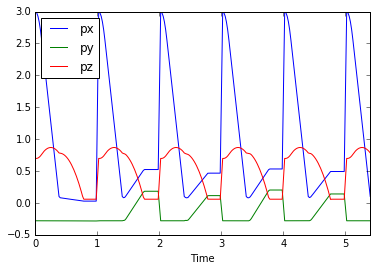

In [13]:
%matplotlib inline
ball_csv=ball_csv.set_index('Time')
ball_csv.plot()

You can see that ball position is initially high when the ball is created, it then decreases until it hits the robot.

## Optimizing the synaptic weight

We define the objective function as being the accumulated **x** position. Let's run many trials with different synaptic weights and see the evolution of accumulated **x** position. For example, with this current trial of synaptic weight 1.0, the accumulated **x** is:

In [ ]:
ball_csv.px.sum()

Run the experiment again with different synaptic weights and plot the results.

In [ ]:
import numpy as np
n_trials =  10
trial_weights = np.linspace(0., 1.5, n_trials)
trial_ball_csv = [tempfile.mkdtemp() for i in range(n_trials)]
#################################################
# Insert code here:
# 1) run the experiments with all the trial_weights
# 2) compute the fitness of each trial
# 3) plot your results
#################################################
weight_costs = []
for i in range(n_trials):
    run_experiment(trial_ball_csv[i], brain_params={'syn_weight': trial_weights[i]})
    csv_file = os.path.join(trial_ball_csv[i], csv_name)
    ball_csv = pandas.read_csv(csv_file)
    weight_costs.append(ball_csv.px.sum())
    
weight_costs_df = pandas.DataFrame({
    'Weight': pandas.Series(trial_weights),
    'Cost': pandas.Series(weight_costs)
})
weight_costs_df.set_index('Weight').plot()